In [1]:
import os
import networkx as nx
import dill as pickle
import matplotlib
import matplotlib.pyplot as plt
from io import BytesIO
from PIL import Image
from copy import deepcopy
import numpy as np
import seaborn as sns

FIRA_CODE_FONT_PATH = 'assets/FiraCode-Regular.ttf'
matplotlib.rc('font',family='serif', serif=['Palatino'])
sns.set(font='serif', font_scale=1.4)
sns.set_style("white", {
        "font.family": "serif",
        "font.weight": "normal",
        "font.serif": ["Times", "Palatino", "serif"],
        'axes.facecolor': 'white',
        'lines.markeredgewidth': 1})

In [2]:
from viz_script import get_stats, get_invalid_actions

names = [
    "Boomerang",
    "ToI-DFS",
    "ToI-BFS",
    "ReAct",
    "Classical",
]

colors = {
    "Boomerang": "#a65628",
    "ToI-DFS": "#ff7f00",
    "ToI-BFS": "#4daf4a",
    "ReAct": "#f781bf",
    "Classical": "#377eb8"
}

log_dirs = [
    "data/final/boomerang", # Boomerang
    "data/final/ToI-DFS", # ToI-DFS
    "data/final/ToI-BFS", # ToI-BFS
    "data/final/ReAct", # ReAct
    "data/final/classical", # Classical
]

results_csv = 'results.csv'
log_files = [
    'log_lazy.txt',
    'log_tot_dfs.txt',
    'log_tot_bfs.txt',
    'log_ReAct.txt',
    'log_fd.txt',
]
hydra_log_file = 'main_script.log'

stats = {}
for name, log_dir, log_file in zip(names, log_dirs, log_files):
    df, llm_calls, llm_token_usage = get_stats(log_dir, results_csv, log_file, hydra_log_file)
    instance_to_invalid_action_count = get_invalid_actions(log_dir, log_file)
    # Dictionary of instance to invalid action count
    # Add invalid action count to the instance's total_edges_expanded
    for instance, invalid_action_count in instance_to_invalid_action_count.items():
        df.loc[df["instance"] == instance, "total_edges_expanded"] += invalid_action_count
    stats[name] = (df, llm_calls, llm_token_usage)

    print("Printing stats for", log_dir)
    success_df = df[df["reached_goal"] == True]
    success_df = df[(df["reached_goal"] == True) & (df["total_edges_expanded"] <= 20)]
    optimal_df = df[(df["actual_length"] == df["optimal_length"]) & (df["reached_goal"] == True)]
    print(f"Success rate: {len(success_df)} / {len(df)}")
    print(f"Optimality rate: {len(optimal_df)} / {len(df)}")
    print(f"Average nodes expanded: {df['total_nodes_expanded'].mean()}")
    print(f"Median nodes expanded: {df['total_nodes_expanded'].median()}")
    print(f"Std nodes expanded: {df['total_nodes_expanded'].std()}")
    print(f"Average edges expanded: {df['total_edges_expanded'].mean()}")
    print(f"Median edges expanded: {df['total_edges_expanded'].median()}")
    print(f"Std edges expanded: {df['total_edges_expanded'].std()}")
    print(f"LLM calls per run: {llm_calls / len(df)}")
    print(f"LLM token usage per run: {llm_token_usage / len(df)}")
    print('\n\n')

Printing stats for data/final/boomerang
Success rate: 465 / 600
Optimality rate: 424 / 600
Average nodes expanded: 10.783333333333333
Median nodes expanded: 9.0
Std nodes expanded: 5.450005488247276
Average edges expanded: 14.543333333333333
Median edges expanded: 11.5
Std edges expanded: 10.232103830765277
LLM calls per run: 5.691666666666666
LLM token usage per run: 38235.725



Printing stats for data/final/ToI-DFS
Success rate: 222 / 600
Optimality rate: 226 / 600
Average nodes expanded: 13.451666666666666
Median nodes expanded: 14.0
Std nodes expanded: 5.895387168965996
Average edges expanded: 19.545
Median edges expanded: 22.0
Std edges expanded: 9.666801612858858
LLM calls per run: 29.425
LLM token usage per run: 24281.618333333332



Printing stats for data/final/ToI-BFS
Success rate: 174 / 600
Optimality rate: 253 / 600
Average nodes expanded: 16.685
Median nodes expanded: 14.0
Std nodes expanded: 9.969190016377345
Average edges expanded: 24.76
Median edges expanded: 21.0
Std 

In [3]:
def fix_graph_styling(graph):
    """Fixes the styling of the graph
    
    TODO: Make original styler abide by this
    """
    for node in graph.nodes:
        # Check if red and, if so, make it orange
        change_color = graph.nodes[node].get("color") == "red"
        model = graph.nodes[node]["model"]
        graph.nodes[node].clear()  # Clear all attributes from the node
        graph.nodes[node]["model"] = model
        if change_color:
            graph.nodes[node]["color"] = "orange"

    for edge in graph.edges:
        change_color = graph[edge[0]][edge[1]].get("color") == "red"
        action = graph[edge[0]][edge[1]]["action"]
        graph[edge[0]][edge[1]].clear()  # Clear all attributes from the edge
        graph[edge[0]][edge[1]]["action"] = action
        if change_color:
            graph[edge[0]][edge[1]]["color"] = "orange"


    graph.graph.clear()  # Clear all attributes from the graph

def visualize_graph(graph, graph_file="", number_nodes=False):
    """Visualizes the graph by saving to file or displaying.
    
    Parameters:
        graph (nx.DiGraph)
            The graph to visualize.
        graph_file (str)
            The name of the file to save the graph to. If empty, the graph is displayed.
        number_nodes (bool)
            Whether to number the nodes in the graph.

    Side Effects:
        - Creates temporary image files
        - Modifies the graph's labels and images
        - Saves the graph to a file
    """
    for i, node in enumerate(graph.nodes):
        graph.nodes[node]["label"] = str(i) if number_nodes else ""
        model = graph.nodes[node]["model"]
        graph.nodes[node]["image"] = model.get_image_path()
        graph.nodes[node]["width"] = "0.75"  # Adjust width
        graph.nodes[node]["height"] = "0.75"  # Adjust height
        graph.nodes[node]["fixedsize"] = "true"  # Ensure fixed size
        graph.nodes[node]["fontsize"] = "10"  # Adjust font size
        # graph.nodes[node]["imagescale"] = "true"  # Ensure images are scaled to fit

    for edge in graph.edges:
        # graph[edge[0]][edge[1]]["label"] = str(graph[edge[0]][edge[1]]["action"])
        graph[edge[0]][edge[1]]["penwidth"] = "0.5"  # Adjust edge thickness
        graph[edge[0]][edge[1]]["arrowsize"] = "0.5"
        graph[edge[0]][edge[1]]["fontsize"] = "8"  # Adjust edge label font size

    pygraphviz_graph = nx.nx_agraph.to_agraph(graph)
    
    # Adjust image size and node spacing
    pygraphviz_graph.graph_attr.update({
        'nodesep': '1.5',  # Adjust node separation
        'ranksep': '0.75',  # Adjust rank separation
        'size': '6,6!',    # Set size of the image
        'dpi': '1000'       # Set DPI (dots per inch) for the image resolution
    })
    
    pygraphviz_graph.layout('dot')

    if graph_file:
        # Create directory if it doesn't exist
        os.makedirs(os.path.dirname(graph_file), exist_ok=True)
        pygraphviz_graph.draw(graph_file)
    else:
        img = Image.open(BytesIO(pygraphviz_graph.draw(format='png')))
        plt.figure(figsize=(6, 6))  # Adjust the figure size as needed
        plt.imshow(img)
        plt.axis('off')
        plt.show()

In [4]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import numpy as np

def plot_success_rate_bar_graph(categories, success_rates, errors, colors=None, title='Success over PlanBench', y_label='Success Rate'):
    # Register the font with Matplotlib

    if colors is None:
        # Define a default base color if no colors are provided
        base_color = plt.cm.Blues
        # Normalize success rates to range [0, 1] for color mapping
        norm = plt.Normalize(min(success_rates), max(success_rates))
        bar_colors = base_color(norm(success_rates))
    else:
        bar_colors = colors

    # Create the bar plot
    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.bar(categories, success_rates, yerr=errors, color=bar_colors, edgecolor='black', linewidth=1.2, capsize=5)

    # Add titles and labels
    ax.set_title(title, fontsize=28, weight='bold')
    ax.set_ylabel(y_label, fontsize=20)

    # Customize tick parameters
    ax.tick_params(axis='x', labelsize=12, rotation=45)  # Rotate x-axis labels
    ax.tick_params(axis='y', labelsize=16)  # Keep y-axis tick labels unchanged
    prop = fm.FontProperties(fname=FIRA_CODE_FONT_PATH)
    for label in ax.get_xticklabels():
        label.set_fontproperties(prop)
    
    # Set y-axis range from 0 to 1
    ax.set_ylim(0, 1)

    # Add value labels on top of the bars
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f'{yval:.2f}', 
                ha='center', va='bottom', fontsize=16, color='black', weight='bold')

    # Remove spines for a cleaner look
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Turn off grid lines
    ax.grid(False)

    # Show plot
    plt.tight_layout()
    plt.show()

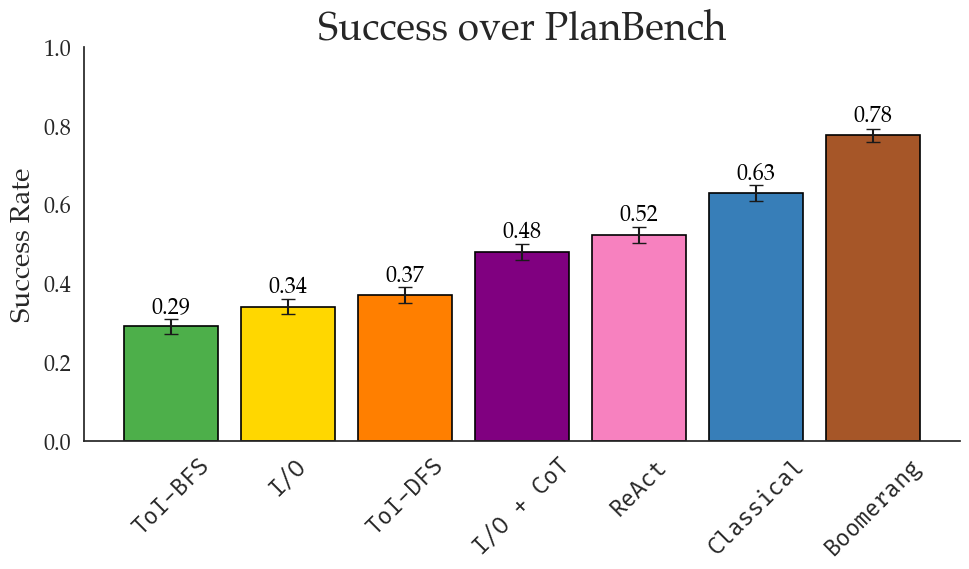

In [5]:
# Plot the success rate of each algorithm as a bar chart in ascending order of success
# Make the x-axis labels the algorithm names
# Make the y-axis label the success rate out of 600

def calculate_success_rate_and_standard_error(success, total):
    success_rate = success / total
    success_distribution = np.concatenate([np.ones(success), np.zeros(total - success)])
    standard_error = np.std(success_distribution) / np.sqrt(total)
    return success_rate, standard_error

# io_e_success = 241
io_e_success = 204
io_e_success_rate, io_e_standard_error = calculate_success_rate_and_standard_error(io_e_success, 600)
# io_e_s_success = 242
io_e_s_success = 288
io_e_s_success_rate, io_e_s_standard_error = calculate_success_rate_and_standard_error(io_e_s_success, 600)

extra_algorithms = [
    ('I/O', io_e_success_rate, io_e_standard_error, '#ffd700'),
    ('I/O + CoT', io_e_s_success_rate, io_e_s_standard_error, '#800080')
]

success_rates = []
standard_errors = []
plot_names = names.copy()
plot_colors = colors.copy()
for name in plot_names:
    df = stats[name][0]
    success_df = df[(df["reached_goal"] == True) & (df["total_edges_expanded"] <= 20)]
    success_rate, standard_error = calculate_success_rate_and_standard_error(len(success_df), len(df))
    success_rates.append(success_rate)
    standard_errors.append(standard_error)
for name, success_rate, standard_error, color in extra_algorithms:
    plot_names.append(name)
    plot_colors[name] = color
    success_rates.append(success_rate)
    standard_errors.append(standard_error)
sorted_names = [name for _, name in sorted(zip(success_rates, plot_names))]
sorted_colors = [plot_colors[name] for name in sorted_names]
sorted_success_rates = sorted(success_rates)
sorted_standard_errors = [standard_errors[plot_names.index(name)] for name in sorted_names]

plot_success_rate_bar_graph(sorted_names, sorted_success_rates, sorted_standard_errors, sorted_colors)


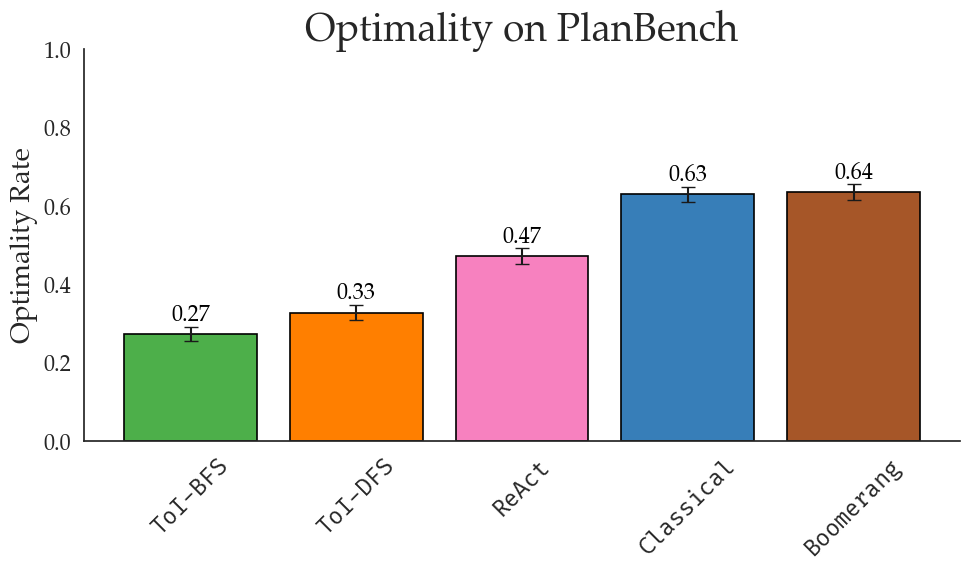

In [6]:
# Optimality rate

optimality_rates = []
standard_errors = []
plot_names = names.copy()
plot_colors = colors.copy()
for name in plot_names:
    df = stats[name][0]
    optimal_df = df[(df["actual_length"] == df["optimal_length"]) & (df["reached_goal"] == True) & (df["total_edges_expanded"] <= 20)]
    _, standard_error = calculate_success_rate_and_standard_error(len(optimal_df), len(df))
    optimality_rates.append(len(optimal_df) / len(df))
    standard_errors.append(standard_error)

sorted_names = [name for _, name in sorted(zip(optimality_rates, plot_names))]
sorted_colors = [plot_colors[name] for name in sorted_names]
sorted_optimality_rates = sorted(optimality_rates)
sorted_optimality_errors = [standard_errors[plot_names.index(name)] for name in sorted_names]

plot_success_rate_bar_graph(sorted_names, sorted_optimality_rates, sorted_optimality_errors, sorted_colors, 'Optimality on PlanBench', 'Optimality Rate')

In [7]:
def plot_grouped_comparison(frequencies, errors, names, colors, overlayed_frequencies=None, overlayed_color=None, x_bounds=(1, 20), x_label='Category', y_label='Frequency'):
    """
    Plots a grouped comparison of histograms.

    Parameters:
    - frequencies: List of arrays containing the frequencies for each histogram.
    - errors: List of standard errors for each histogram.
    - names: List of names/titles for each histogram.
    - colors: List of colors for each histogram.
    - overlayed_frequencies: Array containing the frequencies for the overlayed histogram (default is None).
    - overlayed_color: Color for the overlayed histogram (default is None).
    - x_bounds: Tuple containing the lower and upper bounds for the x-axis (default is (1, 20)).
    - x_label: Label for the x-axis (default is 'Category').
    - y_label: Label for the y-axis (default is 'Frequency').
    """
    # Create subplots
    fig, axes = plt.subplots(figsize=(14, 5), ncols=len(frequencies), sharey=True)

    # Plot each histogram
    for i, ax in enumerate(axes):
        ax.bar(np.arange(x_bounds[0], x_bounds[1]+1), frequencies[i], color=colors[i], edgecolor='black', width=1, alpha=1.0)

        # Overlay one histogram for comparison
        if overlayed_frequencies is not None:
            ax.bar(np.arange(x_bounds[0], x_bounds[1]+1), overlayed_frequencies, color=overlayed_color, edgecolor='black', width=1, alpha=0.5)
        
        # Calculate the weighted mean
        bin_centers = np.arange(x_bounds[0], x_bounds[1] + 1)
        mean_value = np.average(bin_centers, weights=frequencies[i])
        
        # Plot the mean with a dashed line
        ax.axvline(mean_value, color='black', linestyle='dashed', linewidth=1)
        
        # Plot the standard error bars if provided
        if errors is not None and i < len(errors):
            errorbar_y_position = ax.get_ylim()[1] * .8  # Adjusted y position for the error bars
            ax.errorbar(mean_value, errorbar_y_position, xerr=errors[i], fmt='', color='black', capsize=5)
        
        # Get y-limits and set text position slightly to the right of the mean line
        text_y_position = ax.get_ylim()[1] * 0.95
        ax.text(mean_value + 0.5, text_y_position, f'Mean: {mean_value:.2f}', color='black', ha='left', va='top', fontsize=14, fontweight='bold')

        # Set labels
        ax.set_title(names[i], fontsize=20, fontweight='bold')
        prop = fm.FontProperties(fname=FIRA_CODE_FONT_PATH)
        ax.title.set_font_properties(prop)

        ax.set_xlabel(x_label, fontsize=16)
        ax.set_xlim(x_bounds[0] - 0.5, x_bounds[1] + 0.5)
        ax.set_xticks(np.arange(x_bounds[0], x_bounds[1]+1, 10))
        if i == 0:
            ax.set_ylabel(y_label, fontsize=20)

    # Adjust layout
    plt.tight_layout()
    plt.show()

597
600
599
600
600


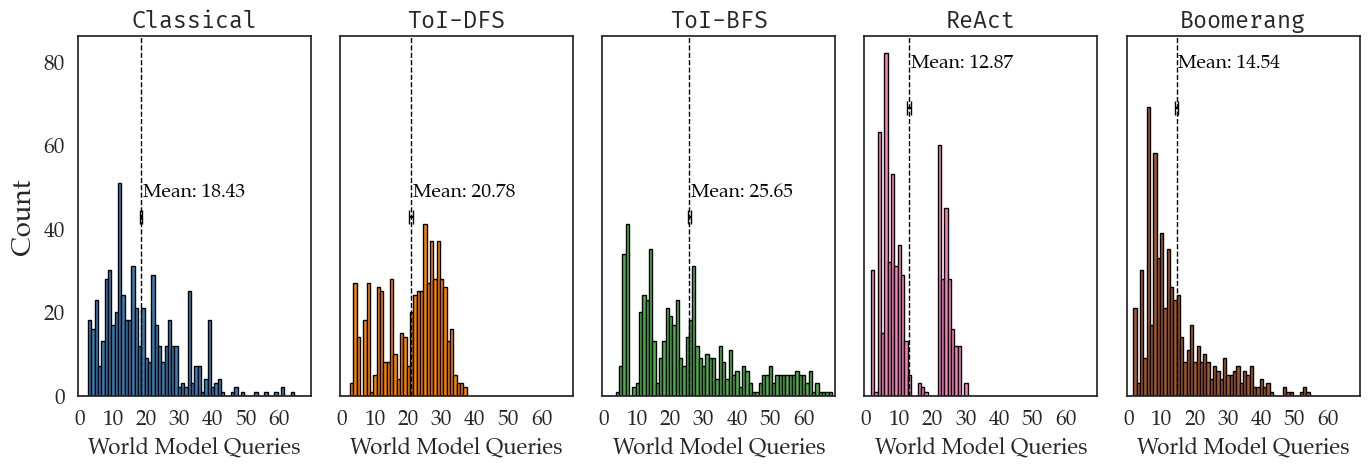

In [8]:
# World Model Query (WMQ) histogram w/ penalty

plot_names = ['Classical', 'ToI-DFS', 'ToI-BFS', 'ReAct', 'Boomerang']
plot_colors = [colors[name] for name in plot_names]
overlayed_frequencies = None
overlayed_color = colors['Boomerang']

total_counts = []
standard_errors = []
overlayed_frequencies = None
bounds = (0, 70)
for name in plot_names:
    counts = []
    weighted_counts = []
    df = stats[name][0]
    # Add penalty
    penalty_df = df.copy()
    penalty_df.loc[penalty_df['total_edges_expanded'] < (penalty_df['optimal_length'] - 1), 'total_edges_expanded'] += 20
    for bound in range(*bounds):
        query_df = penalty_df[(penalty_df["total_edges_expanded"] == bound)]
        counts.append(len(query_df))
        weighted_counts.extend([bound] * len(query_df))
    standard_error = np.std(counts) / np.sqrt(len(weighted_counts))
    print(len(weighted_counts))
    total_counts.append(counts)
    standard_errors.append(standard_error)

x_bounds = (bounds[0], bounds[1] - 1)
plot_grouped_comparison(total_counts, standard_errors, plot_names, plot_colors, overlayed_frequencies, overlayed_color, x_bounds, 'World Model Queries', 'Count')

In [9]:
def plot_group_comparison_percentage(frequencies, errors, names, colors, overlayed_frequencies=None, overlayed_color=None, x_bounds=(1, 20), x_label='Category', y_label='Percentage'):
    """
    Plots a grouped comparison of histograms with y-axis in percentages.

    Parameters:
    - frequencies: List of arrays containing the frequencies for each histogram.
    - errors: List of standard errors for each histogram.
    - names: List of names/titles for each histogram.
    - colors: List of colors for each histogram.
    - overlayed_frequencies: Array containing the frequencies for the overlayed histogram (default is None).
    - overlayed_color: Color for the overlayed histogram (default is None).
    - x_bounds: Tuple containing the lower and upper bounds for the x-axis (default is (1, 20)).
    - x_label: Label for the x-axis (default is 'Category').
    - y_label: Label for the y-axis (default is 'Percentage').
    """
    # Create subplots
    fig, axes = plt.subplots(figsize=(14, 5), ncols=len(frequencies), sharey=True)

    # Plot each histogram
    for i, ax in enumerate(axes):
        # Normalize frequencies to percentages
        total = np.sum(frequencies[i])
        percentages = (frequencies[i] / total) * 100 if total > 0 else np.zeros_like(frequencies[i])

        ax.bar(np.arange(x_bounds[0], x_bounds[1]+1), percentages, color=colors[i], edgecolor='black', width=1, alpha=1.0)

        # Overlay one histogram for comparison (if provided)
        if overlayed_frequencies is not None:
            overlayed_total = np.sum(overlayed_frequencies)
            overlayed_percentages = (overlayed_frequencies / overlayed_total) * 100 if overlayed_total > 0 else np.zeros_like(overlayed_frequencies)
            ax.bar(np.arange(x_bounds[0], x_bounds[1]+1), overlayed_percentages, color=overlayed_color, edgecolor='black', width=1, alpha=0.5)
        
        # Calculate the weighted mean for percentages
        bin_centers = np.arange(x_bounds[0], x_bounds[1] + 1)
        mean_value = np.average(bin_centers, weights=percentages) if np.sum(percentages) > 0 else 0
        
        # Plot the mean with a dashed line
        ax.axvline(mean_value, color='black', linestyle='dashed', linewidth=1)
        
        # Plot the standard error bars if provided
        if errors is not None and i < len(errors):
            errorbar_y_position = ax.get_ylim()[1] * .8  # Adjusted y position for the error bars
            ax.errorbar(mean_value, errorbar_y_position, xerr=errors[i], fmt='', color='black', capsize=5)
        
        # Get y-limits and set text position slightly to the right of the mean line
        text_y_position = ax.get_ylim()[1] * 0.95
        ax.text(mean_value - 8.5, text_y_position, f'Mean: {mean_value:.2f}', color='black', ha='left', va='top', fontsize=12, fontweight='bold')
        
        # Set labels
        ax.set_title(names[i], fontsize=20, fontweight='bold')
        prop = fm.FontProperties(fname=FIRA_CODE_FONT_PATH)
        ax.title.set_font_properties(prop)
        
        ax.set_xlabel(x_label, fontsize=16)
        ax.set_xlim(x_bounds[0] - 0.5, x_bounds[1] + 0.5)
        ax.set_xticks(np.arange(x_bounds[0], x_bounds[1]+1, 10))
        if i == 0:
            ax.set_ylabel(y_label, fontsize=20)

    # Adjust layout
    plt.tight_layout()
    plt.show()

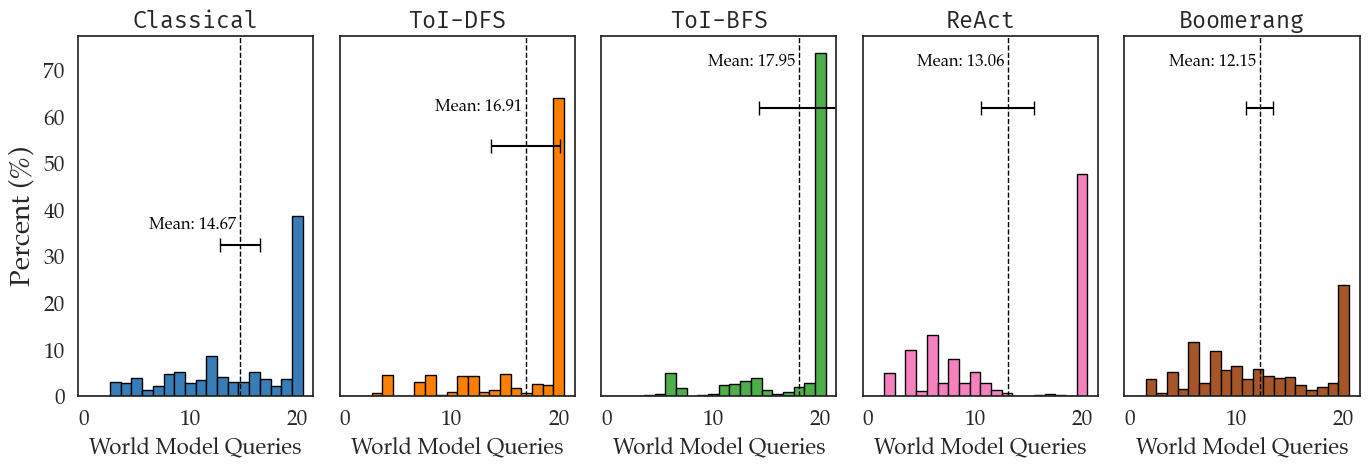

In [10]:
# World Model Query (WMQ) histogram w/ penalty = 20

plot_names = ['Classical', 'ToI-DFS', 'ToI-BFS', 'ReAct', 'Boomerang']
plot_colors = [colors[name] for name in plot_names]
overlayed_frequencies = None
overlayed_color = colors['Boomerang']

total_counts = []
standard_errors = []
overlayed_frequencies = None
bounds = (0, 22)
for name in plot_names:
    counts = []
    weighted_counts = []
    df = stats[name][0]
    # Add penalty
    penalty_df = df.copy()
    penalty_df.loc[penalty_df['reached_goal'] == False, 'total_edges_expanded'] = 20
    penalty_df.loc[penalty_df['total_edges_expanded'] > 20, 'total_edges_expanded'] = 20
    for bound in range(*bounds):
        query_df = penalty_df[(penalty_df["total_edges_expanded"] == bound)]
        counts.append(len(query_df))
        weighted_counts.extend([bound] * len(query_df))
    standard_error = np.std(counts) / np.sqrt(len(weighted_counts))
    total_counts.append(counts)
    standard_errors.append(standard_error)

x_bounds = (bounds[0], bounds[1] - 1)
plot_group_comparison_percentage(total_counts, standard_errors, plot_names, plot_colors, overlayed_frequencies, overlayed_color, x_bounds, 'World Model Queries', 'Percent (%)')

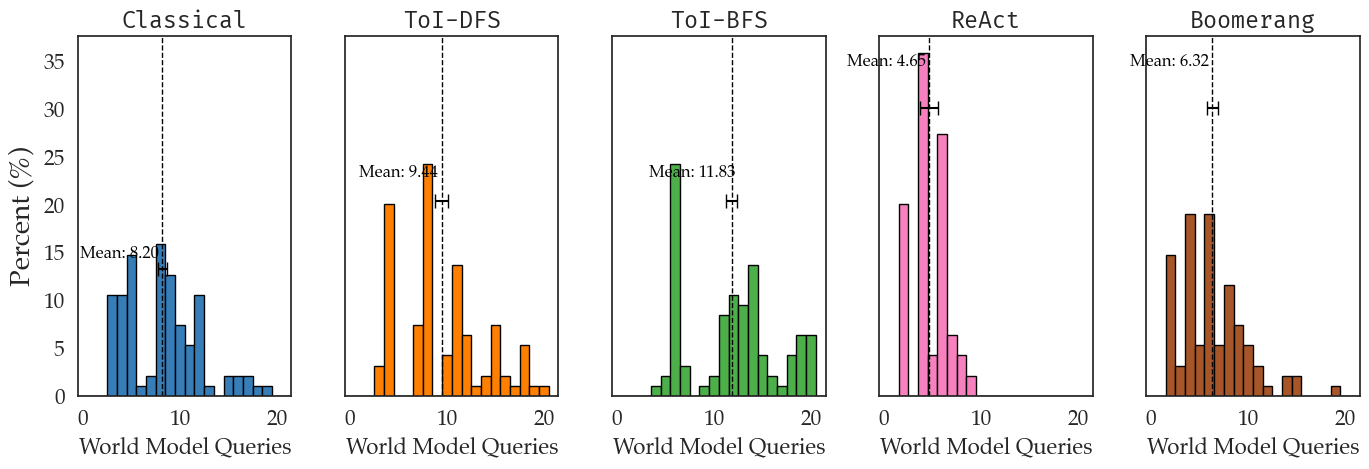

In [11]:
# World Model Query (WMQ) histogram w/ intersection successes

plot_names = ['Classical', 'ToI-DFS', 'ToI-BFS', 'ReAct', 'Boomerang']
plot_colors = [colors[name] for name in plot_names]
overlayed_frequencies = None
overlayed_color = colors['Boomerang']

total_counts = []
standard_errors = []
overlayed_frequencies = None
bounds = (0, 22)

intersection_success_instances = []
for name in plot_names:
    df = stats[name][0]
    success_df = df[(df["reached_goal"] == True) & (df["total_edges_expanded"] <= 20)]
    intersection_success_instances.append(set(success_df["instance"]))
intersection_instances = set.intersection(*intersection_success_instances)

for name in plot_names:
    counts = []
    weighted_counts = []
    df = stats[name][0]
    # Display only intersection instances
    df = df[df["instance"].isin(intersection_instances)]
    # Add penalty
    penalty_df = df.copy()
    penalty_df.loc[penalty_df['total_edges_expanded'] < (penalty_df['optimal_length'] - 1), 'total_edges_expanded'] = 20
    # penalty_df.loc[penalty_df['reached_goal'] == False, 'total_edges_expanded'] = 20
    penalty_df.loc[penalty_df['total_edges_expanded'] > 20, 'total_edges_expanded'] = 20
    for bound in range(*bounds):
        query_df = penalty_df[(penalty_df["total_edges_expanded"] == bound)]
        counts.append(len(query_df))
        weighted_counts.extend([bound] * len(query_df))
    standard_error = np.std(counts) / np.sqrt(len(weighted_counts))
    total_counts.append(counts)
    standard_errors.append(standard_error)

x_bounds = (bounds[0], bounds[1] - 1)
plot_group_comparison_percentage(total_counts, standard_errors, plot_names, plot_colors, overlayed_frequencies, overlayed_color, x_bounds, 'World Model Queries', 'Percent (%)')

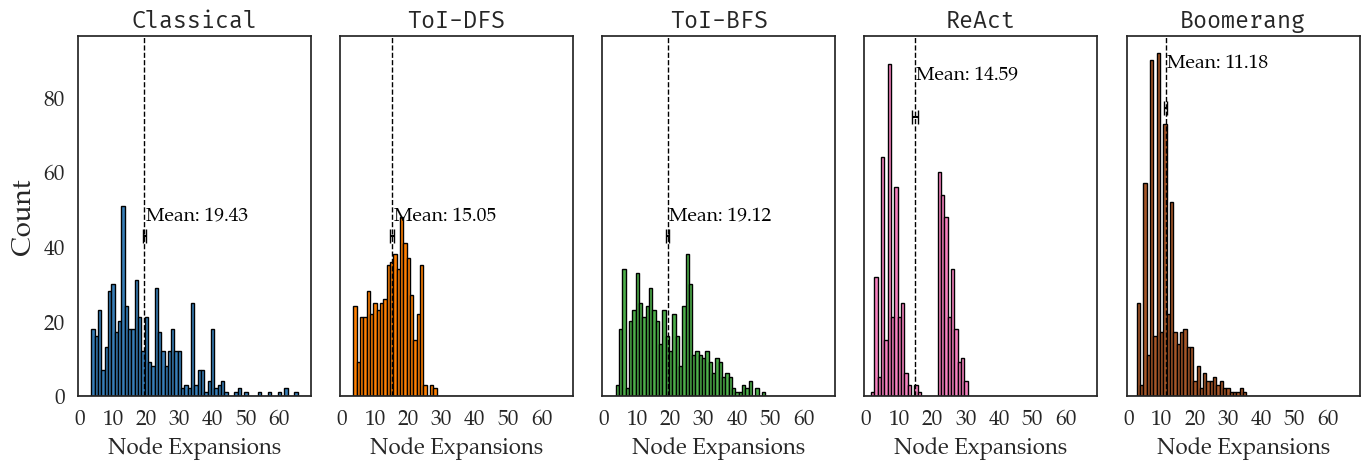

In [12]:
# Node Expansion (NE) histogram w/ penalty

plot_names = ['Classical', 'ToI-DFS', 'ToI-BFS', 'ReAct', 'Boomerang']
plot_colors = [colors[name] for name in plot_names]
overlayed_frequencies = None
overlayed_color = colors['Boomerang']

total_counts = []
overlayed_frequencies = None
bounds = (0, 70)
for name in plot_names:
    counts = []
    weighted_counts = []
    df = stats[name][0]
    # Add penalty
    penalty_df = df.copy()
    penalty_df.loc[penalty_df["total_nodes_expanded"] < penalty_df['optimal_length'], 'total_nodes_expanded'] += 20
    for bound in range(*bounds):
        query_df = penalty_df[(penalty_df["total_nodes_expanded"] == bound)]
        counts.append(len(query_df))
        weighted_counts.extend([bound] * len(query_df))
    standard_error = np.std(counts) / np.sqrt(len(weighted_counts))
    total_counts.append(counts)
    standard_errors.append(standard_error)

x_bounds = (bounds[0], bounds[1] - 1)
plot_grouped_comparison(total_counts, standard_errors, plot_names, plot_colors, overlayed_frequencies, overlayed_color, x_bounds, 'Node Expansions', 'Count')

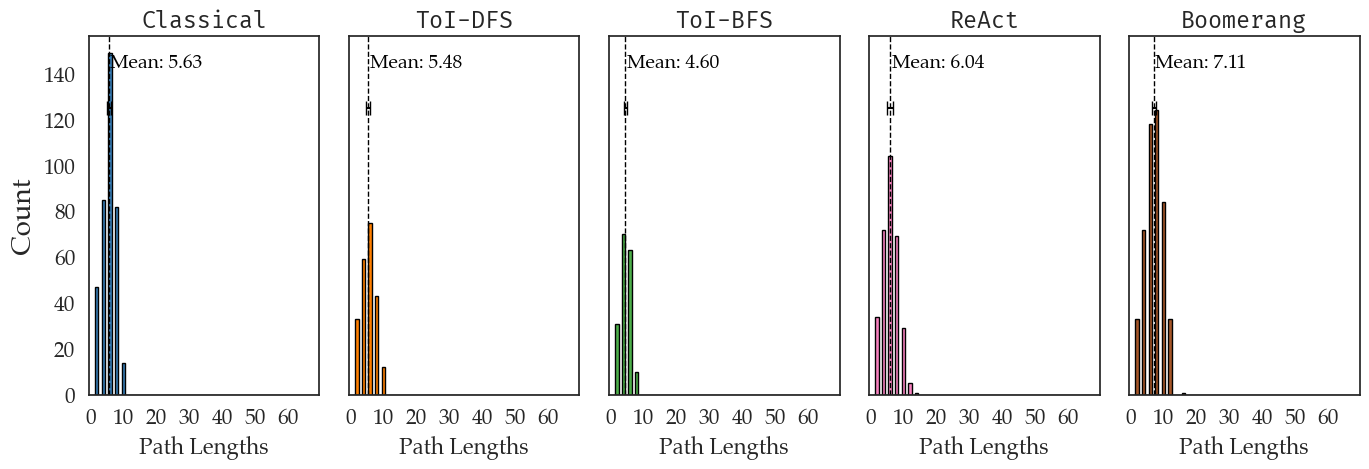

In [13]:
# Histogram over path lengths

plot_names = ['Classical', 'ToI-DFS', 'ToI-BFS', 'ReAct', 'Boomerang']
plot_colors = [colors[name] for name in plot_names]
overlayed_frequencies = None
overlayed_color = colors['Boomerang']

total_counts = []
overlayed_frequencies = None
bounds = (0, 70)

for name in plot_names:
    counts = []
    weighted_counts = []
    df = stats[name][0]
    for bound in range(*bounds):
        query_df = df[(df["actual_length"] == bound) & (df["reached_goal"] == True) & (df["total_edges_expanded"] <= 20)]
        counts.append(len(query_df))
        weighted_counts.extend([bound] * len(query_df))
    standard_error = np.std(counts) / np.sqrt(len(weighted_counts))
    total_counts.append(counts)
    standard_errors.append(standard_error)

x_bounds = (bounds[0], bounds[1] - 1)
plot_grouped_comparison(total_counts, standard_errors, plot_names, plot_colors, overlayed_frequencies, overlayed_color, x_bounds, 'Path Lengths', 'Count')

In [14]:
import matplotlib.pyplot as plt
import numpy as np

def plot_grouped_bar_graph(categories, subcategory_names, counts, standard_errors, colors=None, title='Path Distributions', y_label='Count', totals=None):
    # Number of categories and number of sub-categories
    n_categories = len(categories)
    n_sub_categories = len(subcategory_names)
    
    # Setting up the bar width and positions
    bar_width = 0.2  # Decrease the bar width to add more spacing between groups
    spacing = 0.1     # Additional spacing between groups
    indices = np.arange(n_categories) * (n_sub_categories * bar_width + spacing)
    
    # Initialize the plot with a larger figure size
    fig, ax = plt.subplots(figsize=(12, 6))  # Increase figure size for better visibility
    
    # Default colors if none provided
    if colors is None:
        colors = plt.cm.get_cmap('tab10', n_sub_categories).colors
    
    # Plotting each sub-category
    for i in range(n_sub_categories):
        ax.bar(indices + i * bar_width, [count[i] for count in counts], bar_width,
               label=subcategory_names[i], yerr=[se[i] for se in standard_errors], color=colors[i % len(colors)], capsize=5)

    # Adding totals as dashed lines
    if totals is not None:
        for idx, total in zip(indices, totals):
            ax.axhline(y=total, xmin=(idx - bar_width / 2) / (indices[-1] + bar_width * (n_sub_categories - 1) + spacing), 
                       xmax=(idx + bar_width * (n_sub_categories - 0.5) + spacing) / (indices[-1] + bar_width * (n_sub_categories - 1) + spacing), 
                       color='black', linestyle='--', linewidth=1, label='Total' if idx == indices[0] else "")
    
    # Adding labels and title
    ax.set_xlabel('Path Lengths', fontsize=16)
    ax.set_ylabel(y_label, fontsize=16)
    ax.set_title(title, fontsize=20, weight='bold')
    ax.set_xticks(indices + bar_width * (n_sub_categories - 1) / 2)
    ax.set_xticklabels(categories, fontsize=16)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    # Add font properties to each subcategory in legend
    prop = fm.FontProperties(fname=FIRA_CODE_FONT_PATH)
    for text in ax.get_legend().get_texts():
        if text.get_text() != 'Total':
            text.set_fontproperties(prop)
    
    # Adjust the plot to make space for the legend
    plt.subplots_adjust(right=0.75)  # Adjust the right side to make room for the legend
    
    # Display the plot
    plt.show()


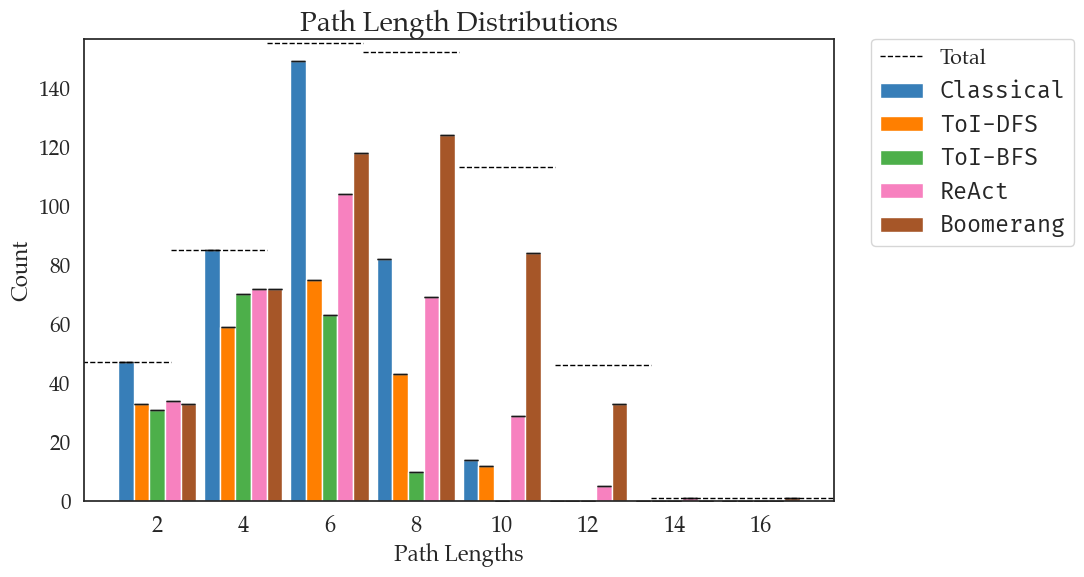

In [15]:
# Plot the path length distribution for each algorithm

plot_names = ['Classical', 'ToI-DFS', 'ToI-BFS', 'ReAct', 'Boomerang']
plot_colors = [colors[name] for name in plot_names]

total_counts = []
total_standard_errors = []
categories = stats['Boomerang'][0]["optimal_length"].unique()
category_names = [str(category) for category in sorted(categories)]

for name in plot_names:
    counts = []
    standard_errors = []
    df = stats[name][0]
    for category in sorted(categories):
        query_df = df[(df["actual_length"] == category) & (df["reached_goal"] == True) & (df["total_edges_expanded"] <= 20)]
        counts.append(len(query_df))
        _, standard_error = calculate_success_rate_and_standard_error(len(query_df), len(df))
        standard_errors.append(0)
    total_counts.append(counts)
    total_standard_errors.append(standard_errors)

total = []
for category in sorted(categories):
    total.append(len(df[(df["optimal_length"] == category)]))

transposed_counts = list(map(list, zip(*total_counts)))
transposed_standard_errors = list(map(list, zip(*total_standard_errors)))

plot_grouped_bar_graph(category_names, plot_names, transposed_counts, transposed_standard_errors, plot_colors, 'Path Length Distributions', 'Count', total)

In [16]:
def stacked_bar_plot(data, categories, labels, colors, title='Stacked Bar Plot', ylabel='Values'):
    """
    Create a stacked bar plot with dynamic number of categories.

    Parameters:
    data (2D list or numpy array): The data to plot, each inner list/array represents a bar.
                                   Shape should be (n_bars, n_categories).
    categories (list of str): The names of the categories.
    labels (list of str): The labels for each bar.
    title (str): The title of the plot.
    ylabel (str): The label for the y-axis.

    Example:
    data = [[5, 10, 15], [7, 14, 21], [3, 6, 9]]
    categories = ['Category 1', 'Category 2', 'Category 3']
    labels = ['Bar 1', 'Bar 2', 'Bar 3']
    """
    
    # Convert data to numpy array for easier manipulation
    data = np.array(data)
    
    # Get number of bars and number of categories
    num_bars, num_categories = data.shape
    
    # Set up the figure and axis
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Create the bars for each category
    bar_width = 0.6
    indices = np.arange(num_bars)
    
    # Initialize the bottom array
    bottom = np.zeros(num_bars)

    # Plot each category
    for i in range(num_categories):
        p = plt.bar(indices, data[:, i], bar_width, bottom=bottom, label=categories[i], color=colors[i])
        
        # Add value annotations to the bars
        for rect in p:
            height = rect.get_height()
            if height > 0:
                ax.annotate('{:.0f}'.format(height),
                            xy=(rect.get_x() + rect.get_width() / 2, rect.get_y() + height / 2),
                            xytext=(0, 0),  # No offset
                            textcoords="offset points",
                            ha='center', va='center', fontsize=10, color='black', weight='bold')

        bottom += data[:, i]

    # Add labels, title and legend
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xticks(indices)
    ax.set_xticklabels(labels)
    ax.legend()

    # Update the font properties for the x categories
    prop = fm.FontProperties(fname=FIRA_CODE_FONT_PATH)
    for label in ax.get_xticklabels():
        label.set_fontproperties(prop)
    
    # Fix legend so no overlapping occurs
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    
    # Display the plot
    plt.tight_layout()
    plt.show()

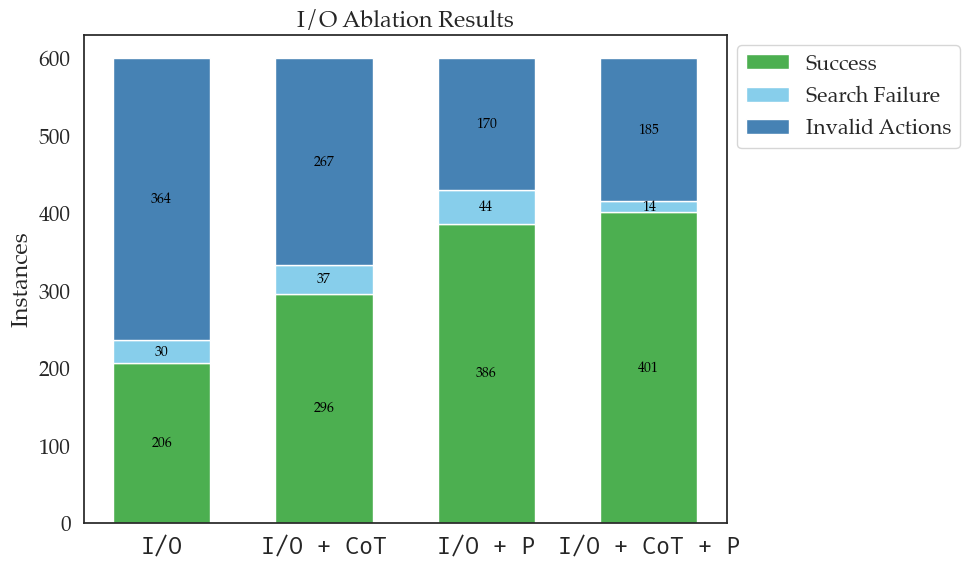

In [17]:
# I/O Ablation Results
categories = ['Success', 'Search Failure', 'Invalid Actions']
#gpt-4
# results = [
#     ('I/O', [241, 69, 290]),
#     ('I/O + CoT', [242, 63, 295]),
#     ('I/O + P', [324, 80, 196]),
#     ('I/O + CoT + P', [349, 17, 234])
# ]
#gpt-4-turbo
results = [
    ('I/O', [206, 30, 364]),
    ('I/O + CoT', [296, 37, 267]),
    ('I/O + P', [386, 44, 170]),
    ('I/O + CoT + P', [401, 14, 185])
]
labels, data = zip(*results)
plot_colors = ['#4CAF50', '#87CEEB', '#4682B4'] 
stacked_bar_plot(data, categories, labels, plot_colors, title='I/O Ablation Results', ylabel='Instances')